# Introduction

In this notebook, we demonstrate an example flow of our manifold analysis experiments and include code to visualise our results. The steps outlined follow the methodology of Mamou et al. with modifications to sampling and evaluation as explained in the report.

If you intend to rerun the analysis and not just use our precomputed results, please follow our installation guide at https://github.com/jim-dilkes/manifold-pruning.

IMPORTANT: if you are running the notebook on Google Colab, please upload demo.zip to Colab and unzip using the cell below. If you are running it locally without cloning our repo, make sure the zip file is in the same folder as the notebook and unzip. If you are running the notebook locally from the repo, DO NOT unzip the file and proceed directly to the next section.

In [ ]:
!unzip demo.zip

# Example experiment

In [1]:
import os
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt

DATASET_BASE = 'demo/data/experiments'
FEATURES_BASE = 'demo/data/features'
MASKS_BASE = 'models/masks/bert-base-uncased-squad2/squad_v2'
RESULTS_BASE = 'demo/data/results'

### Sample dataset files

By sampling sentences from the dataset and converting them to the appropriate format for the MFTMA analysis, we record 2 files: sample_seed, containing the identifiers of sampled questions and relevant_pos_tags, containing the set of all POS tags from the sampled questions (both standard and ambiguous). We also need a dataset file containing a subset of sentences from SQuAD 2.0 which are appropriate for our experiments as explained in the report. This can be found in data/experiments/FINAL_Q.pkl and is required for the next step when we have to access the sampled sentences. As an example, we will use data sampled for our experiment #1.

In [4]:
experiment_id = 1
dataset_file = os.path.join(DATASET_BASE, 'FINAL_Q.pkl')
tag_file = os.path.join(DATASET_BASE, f'relevant_pos_tags_{experiment_id}.txt')
sample = os.path.join(DATASET_BASE, f'sample_seed_{experiment_id}.pkl')

If you wish to rerun the experiment on new set of sample sentences, generate new dataset files by running the cell below. Even though this is a very quick process, be aware that running an end-to-end experiment flow can take 2-3 hours (see next sections).

In [5]:
script_path = os.path.join('src', 'prepare_data.py')
sample = os.path.join(DATASET_BASE, 'sample_seed_demo.pkl')
tag_file = os.path.join(DATASET_BASE, 'relevant_pos_tags_demo.txt')

os.system(f'python {script_path} \
    --sample {sample} \
    --relevant_tags {tag_file}')

0

### Extract features

To extract features, we pass the sampled questions through layers of the model, recording the representation of each token after each layer. As an example, we will use a model pruned to 80% using the latency cost. Feature extraction usually takes a couple of minutes so feel free to skip this step. All results are precomputed so you will be able to visualise them at the end.

If you wish to rerun the extraction, use the cell below. Note that models and masks are needed for this step, so either run the snippet locally or upload "models" directory to colab (~5.3GB).

In [6]:
pruning_perc = 80
script_path = os.path.join('src', 'feature_extract.py')
feature_dir = os.path.join(FEATURES_BASE, f'{pruning_perc}Pruned')
masks_dir = os.path.join(MASKS_BASE, 'latency', f'{round((100 - pruning_perc) / 100, 1)}/seed_0')

os.system(f'python {script_path} \
        --dataset_file {dataset_file} \
        --tag_file {tag_file} \
        --sample {sample} \
        --pruning_metric latency \
        --pruned_percentage {pruning_perc} \
        --masks_dir {masks_dir} \
        --feature_dir {feature_dir}')

1

### Running manifold analysis

Having computed representations of tokens in sampled sentences, we are ready to run the manifold analysis by supplying the directory with extracted representations. Similarly to previous case, we just load the precomputed results. Based on our experience, a full MFTMA analysis for a single model usually takes 2-3 hours. Nonetheless, if you wish to rerun the analysis, find the command in the second cell below.

In [ ]:
script_path = os.path.join('src', 'mftma_analysis.py')
mftma_analysis_dir = os.path.join(RESULTS_BASE, 'demo_results', f'{pruning_perc}Pruned')

os.system(f'python {script_path} \
        --pruning_metric latency \
        --feature_dir {feature_dir} \
        --mftma_analysis_dir {mftma_analysis_dir}')

### Plotting results

The last step remaining is to plot the results of the analysis. This averages the statistics over all manifolds in the experiment for each layer and visualises the evolution of each statistic.

In [2]:
def generate_plot(mftma_analysis_dir, num_layers=12):
    capacities = []
    radii = []
    dimensions = []
    correlations = []

    for layer in range(1,num_layers+1):
        temp_data = pkl.load(open(os.path.join(mftma_analysis_dir,str(layer)+'.pkl'), 'rb+'))
        a = 1 / np.mean(1 / temp_data['a'])
        r = np.mean(temp_data['r'])
        d = np.mean(temp_data['d'])
        r0 = temp_data['r0']
        if layer == 1:
            norm_a = np.abs(a)
            norm_r = np.abs(r)
            norm_d = np.abs(d)
            norm_r0 = np.abs(r0)

        a /= norm_a
        r /= norm_r
        d /= norm_d
        r0 /= norm_r0
        print("{} capacity: {:4f}, radius {:4f}, dimension {:4f}, correlation {:4f}".format(
            'LAYER_' + str(layer), a, r, d, r0))

        capacities.append(a)
        radii.append(r)
        dimensions.append(d)
        correlations.append(r0)

    fig, axes = plt.subplots(1, 4, figsize=(18, 4))

    axes[0].plot(capacities, linewidth=5)
    axes[1].plot(radii, linewidth=5)
    axes[2].plot(dimensions, linewidth=5)
    axes[3].plot(correlations, linewidth=5)

    axes[0].set_ylabel(r'$\alpha_M$', fontsize=18)
    axes[1].set_ylabel(r'$R_M$', fontsize=18)
    axes[2].set_ylabel(r'$D_M$', fontsize=18)
    axes[3].set_ylabel(r'$\rho_{center}$', fontsize=18)

    xticklabels = [i for i in range(1,num_layers+1)]
    for ax in axes:
        ax.set_xticks([i for i, _ in enumerate(xticklabels)])
        ax.set_xlabel('Layer')
        ax.set_xticklabels(xticklabels, rotation=90, fontsize=16)
        ax.tick_params(axis='both', which='major', labelsize=14)

    plt.tight_layout()
    plt.show()

LAYER_1 capacity: 1.000000, radius 1.000000, dimension 1.000000, correlation 1.000000
LAYER_2 capacity: 1.028646, radius 1.003170, dimension 0.974493, correlation 0.889534
LAYER_3 capacity: 1.035160, radius 1.010805, dimension 0.973503, correlation 0.869342
LAYER_4 capacity: 1.029904, radius 0.995196, dimension 0.982670, correlation 0.910753
LAYER_5 capacity: 1.033442, radius 1.017604, dimension 0.974601, correlation 0.918597
LAYER_6 capacity: 0.965183, radius 0.968613, dimension 1.072930, correlation 0.915275
LAYER_7 capacity: 0.953177, radius 0.919957, dimension 1.114010, correlation 0.944382
LAYER_8 capacity: 0.916943, radius 0.924090, dimension 1.147596, correlation 1.095046
LAYER_9 capacity: 0.939397, radius 0.911780, dimension 1.131264, correlation 1.256126
LAYER_10 capacity: 0.897523, radius 0.925318, dimension 1.174071, correlation 1.324038
LAYER_11 capacity: 0.903180, radius 0.922845, dimension 1.170778, correlation 1.462547
LAYER_12 capacity: 0.907952, radius 0.953373, dimens

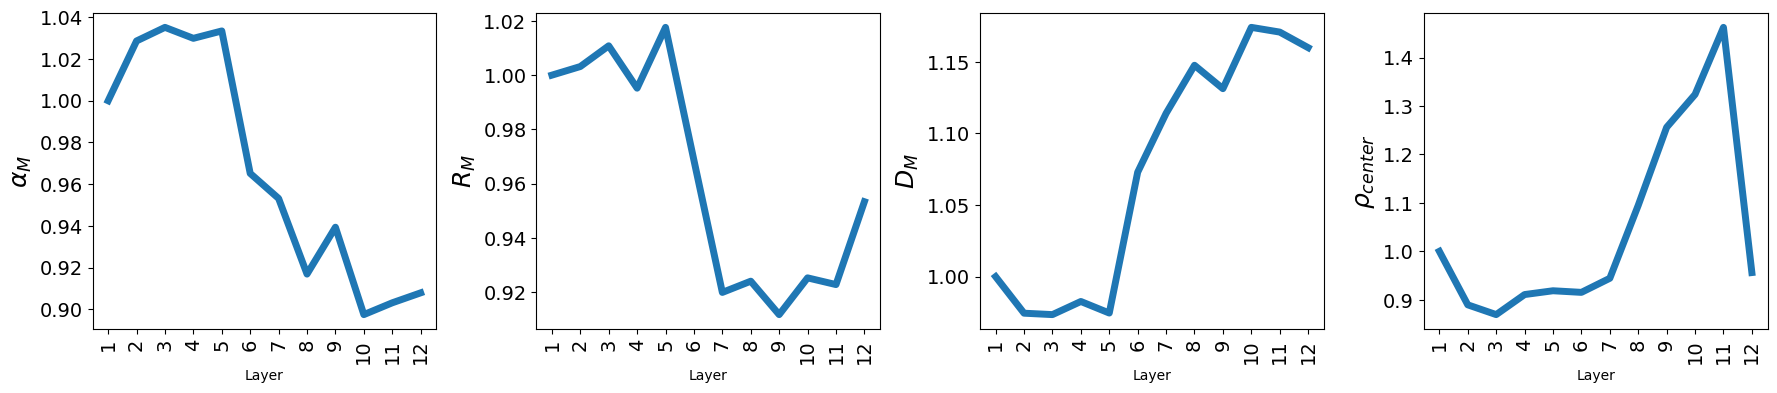

In [4]:
pruning_perc = 80
mftma_analysis_dir = os.path.join(RESULTS_BASE, 'demo_results', f'{pruning_perc}Pruned')

generate_plot(mftma_analysis_dir)

Note that this was just a demonstration of the analysis computation on a single model for a single experiment. As you probably noticed, we modified the original code such that we can easily execute this flow on any of our pruned models. To see our top level script with the complete experiment setup, check src/run_all_experiments.py

# Visualising the results

### Manifold analysis

This section serves as a visualisation tool for the results we report. It shows the average value of manifold statistics over 5 experiments we performed. Choose an experiment number and pruning metric (latency, mac, size, random) to see the manifolds statistics of all pruned models for a given metric. Raw values can be found in csv files in demo/data/results/full_results.

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd

RESULTS_BASE = 'demo/data/results'

In [6]:
'''
PARAMETERS:

pruning_metric: choose a pruning metric to plot the statistics of all pruned models for that metric
                choices: [latency, mac, size, random]
normalised: if True, plots statistics normalised by the 1st layer
'''

pruning_metric = 'random' 
normalised = True 

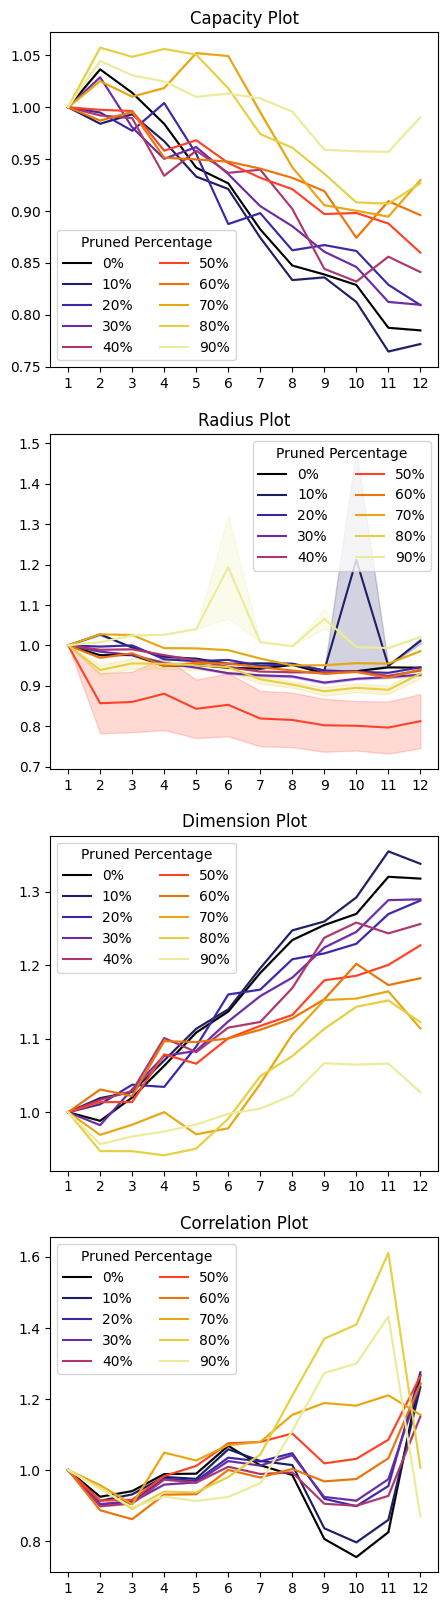

In [7]:
def generate_plot_avg(df, perc_range, n_runs, normed=False):
    fig, axes = plt.subplots(4, 1, figsize=(5, 20))
    d_names = {'Capacity':3, 'Radius':4, 'Dimension':5, 'Correlation':6}
    colors = cm.CMRmap(np.linspace(0,1,len(perc_range)+1))
    
    for i, (field, val) in enumerate(d_names.items()):
        if normed:
            val += 4
        cnt = 0
        for perc in perc_range:
            line = df.loc[(df['Percentage'] == perc)].values[:, val].astype(np.float64).reshape(n_runs, 12).mean(axis=0)
            var = df.loc[(df['Percentage'] == perc)].values[:, val].astype(np.float64).reshape(n_runs, 12).var(axis=0)
            axes[i].plot(np.arange(1,13), line, color=colors[cnt], label=str(perc) + '%')
            axes[i].fill_between(np.arange(1,13), line-var, line+var, color=colors[cnt], alpha=0.2)
            cnt += 1
            axes[i].set_title(field + ' Plot')
            axes[i].set_xticks(np.arange(1,13))

        axes[i].legend(ncol=2, title='Pruned Percentage')
        
    plt.show()
    
results_file_path = os.path.join(RESULTS_BASE, 'full_results', 'mftma', f'{pruning_metric}.csv')
df = pd.read_csv(results_file_path)
perc_range = range(0,90,10) if pruning_metric == 'latency' else range(0,100,10)
n_runs = 4 if pruning_metric == 'latency' else 5

generate_plot_avg(df, perc_range, n_runs, normalised)

### Masks

This code is to visualise evolution of masks generated by the pruning algorithm for each cost as we increase the pruning percentage.

In [8]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from IPython.display import Image as IPyImage

RESULTS_BASE = 'demo/data/results'
MASKS_BASE = os.path.join(RESULTS_BASE, 'full_results', 'masks')

D:\Anaconda3\envs\snlp-new\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
'''
PARAMETERS:

pruning_metric: choose a pruning metric to plot the masks of all pruned models for that metric
                choices: [latency, mac, size, random]
'''

pruning_metric = 'size' 

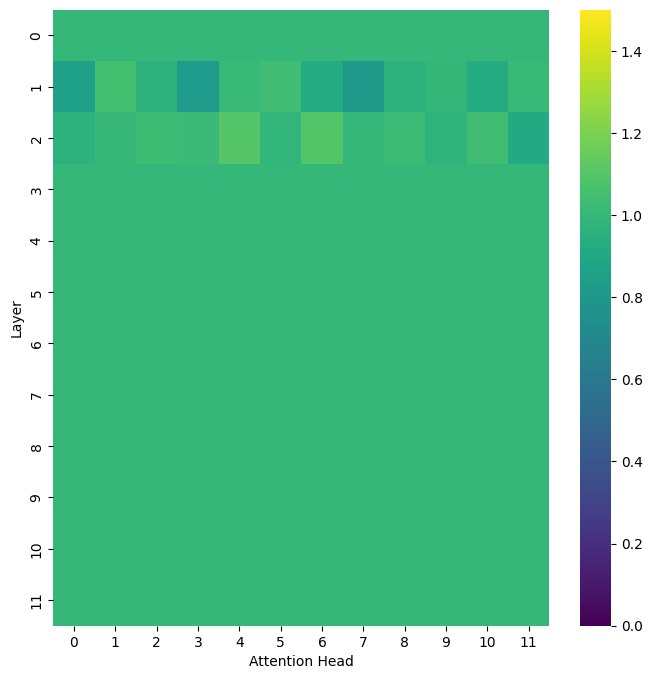

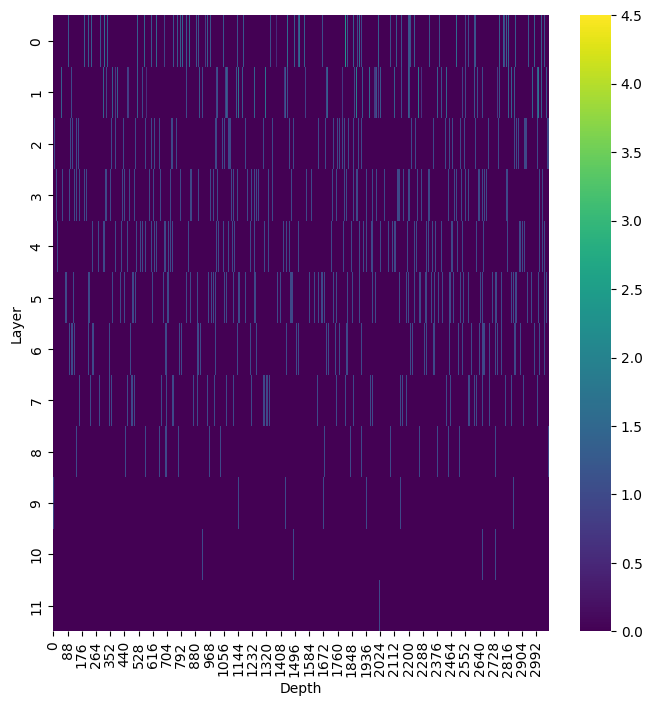

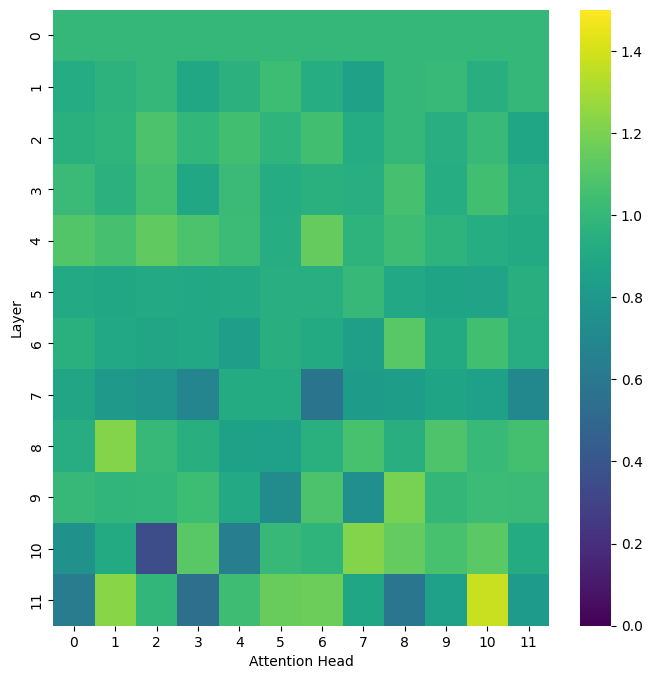

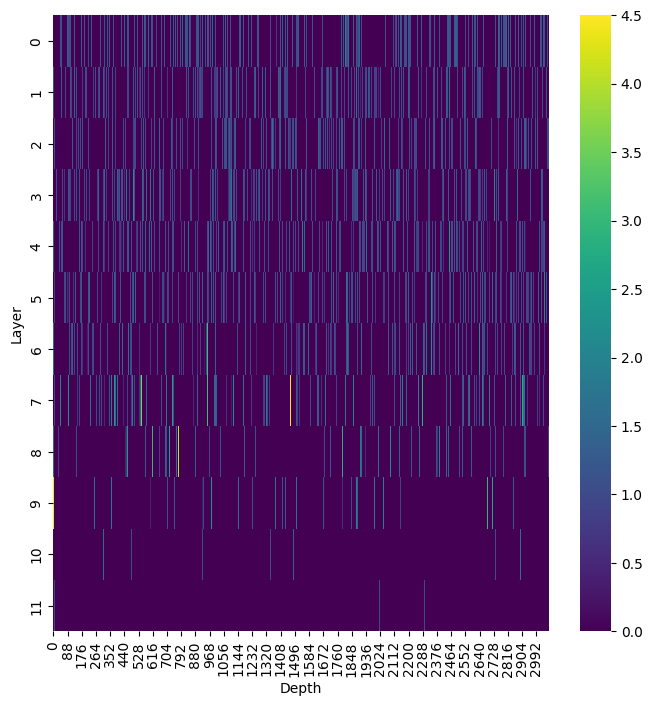

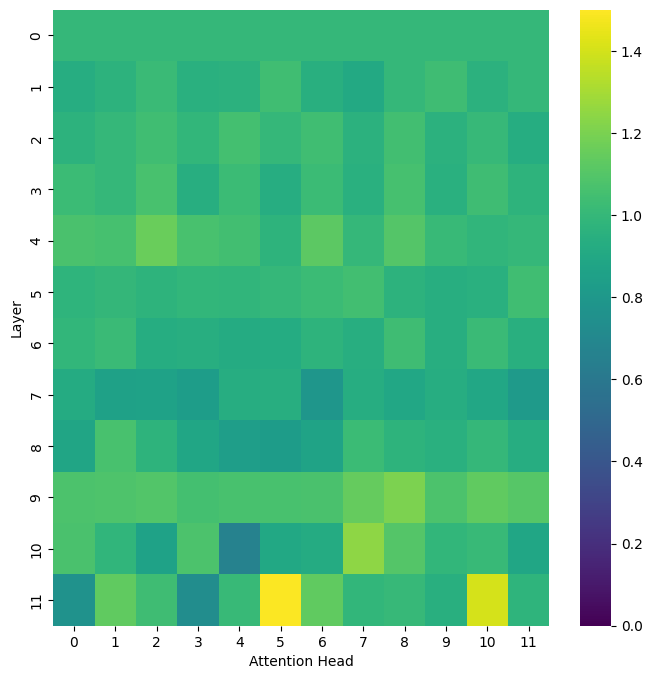

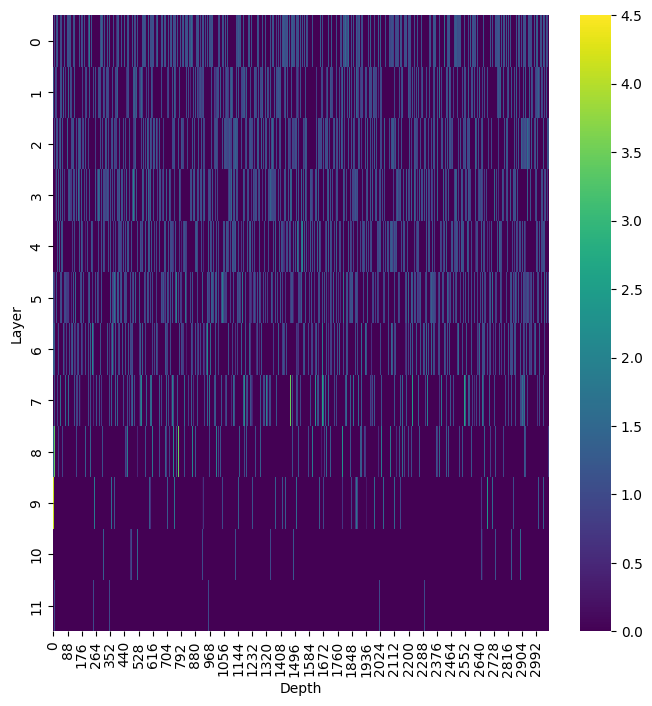

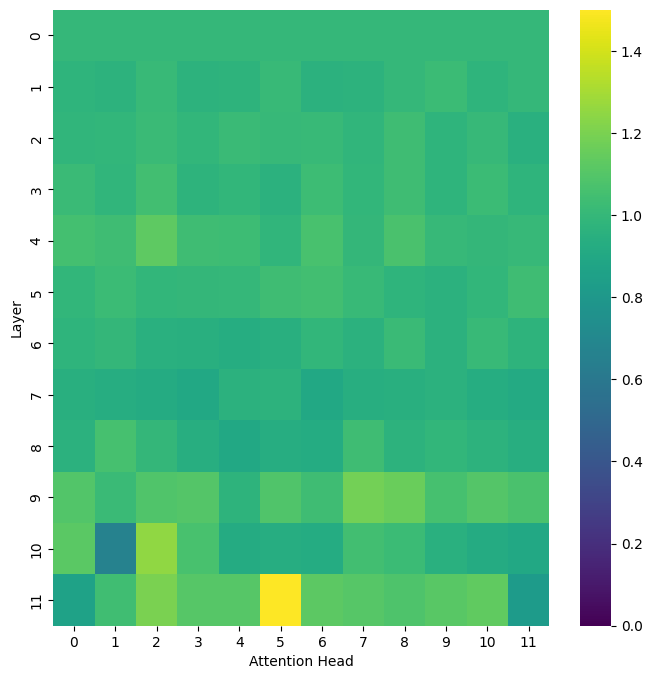

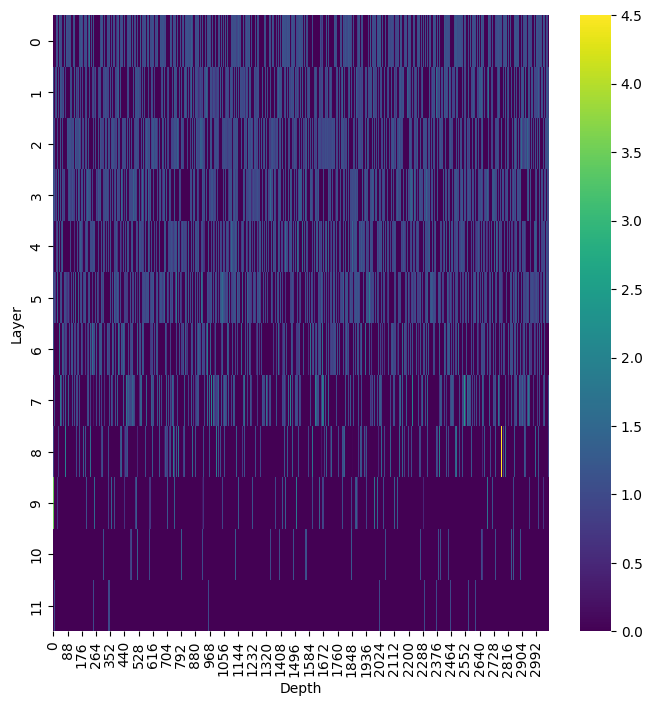

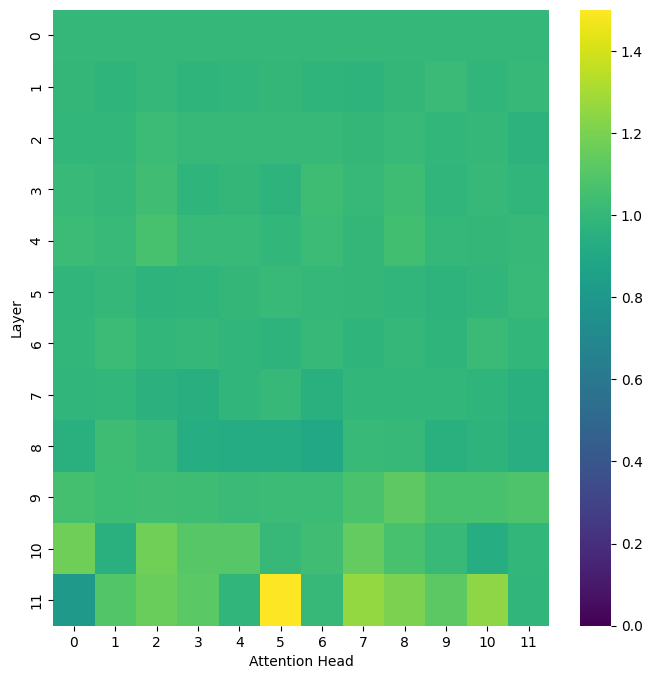

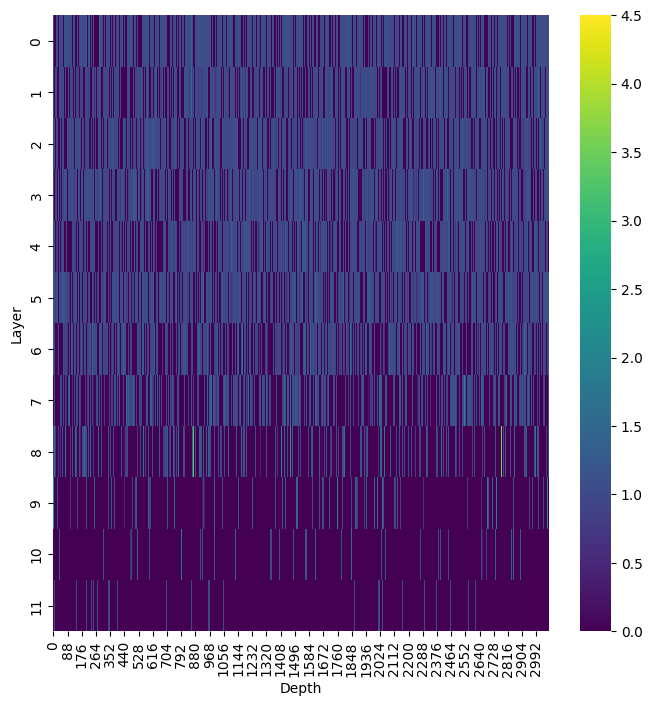

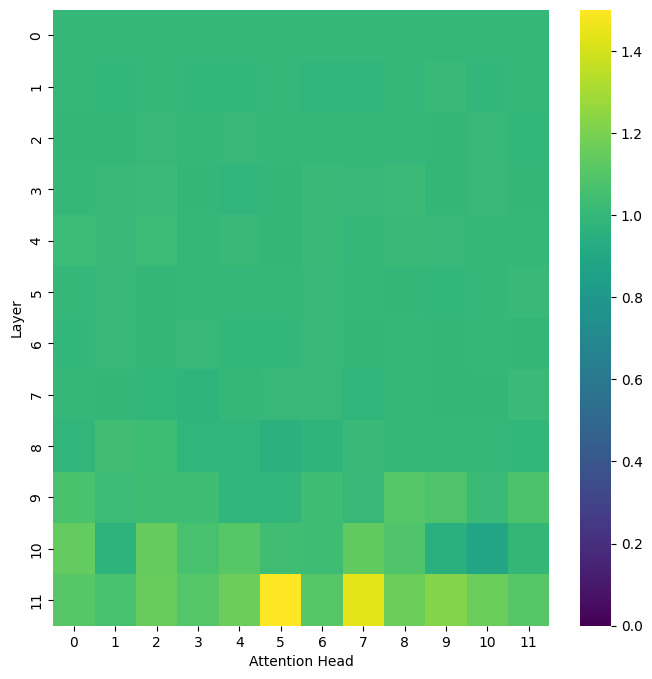

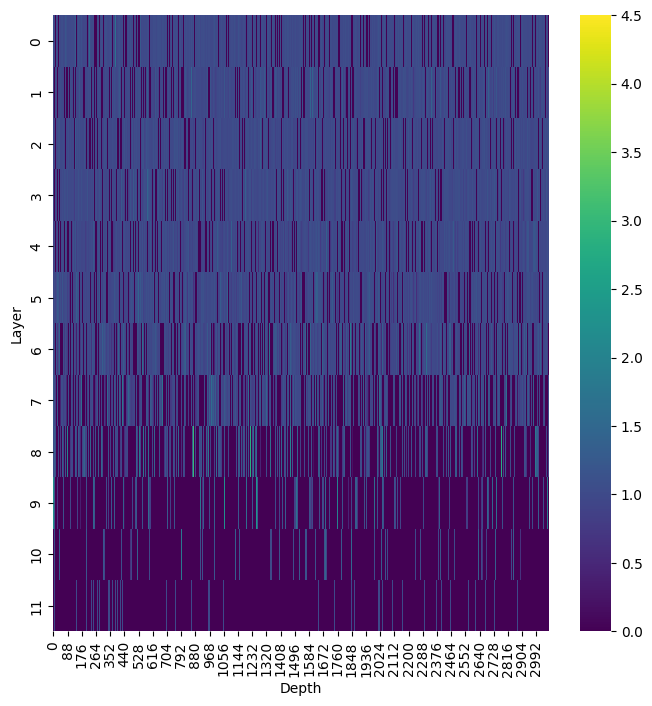

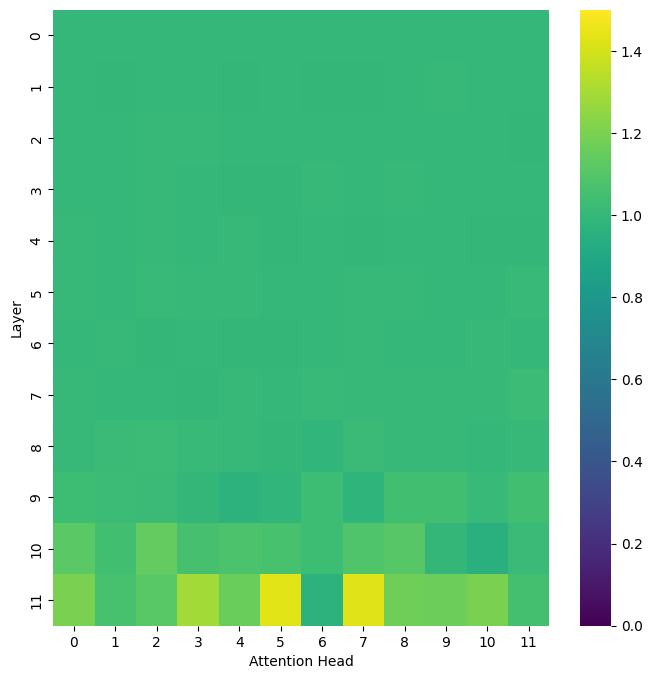

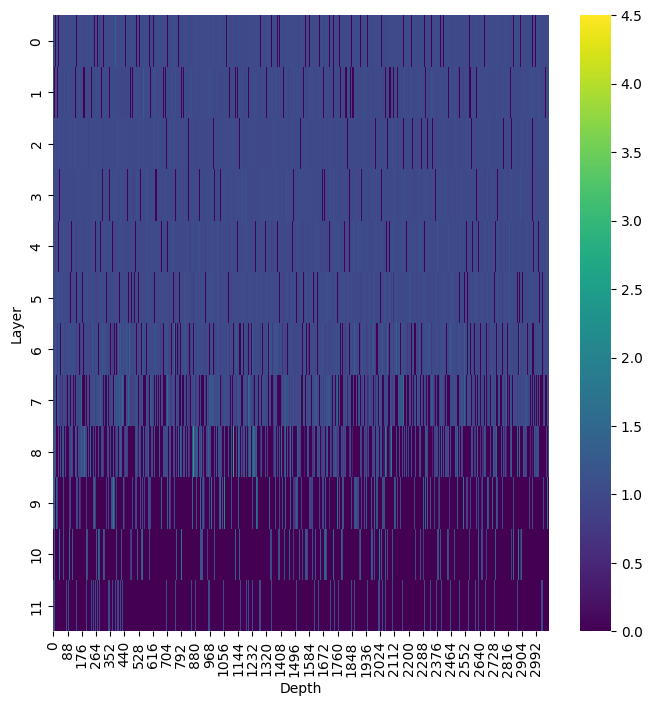

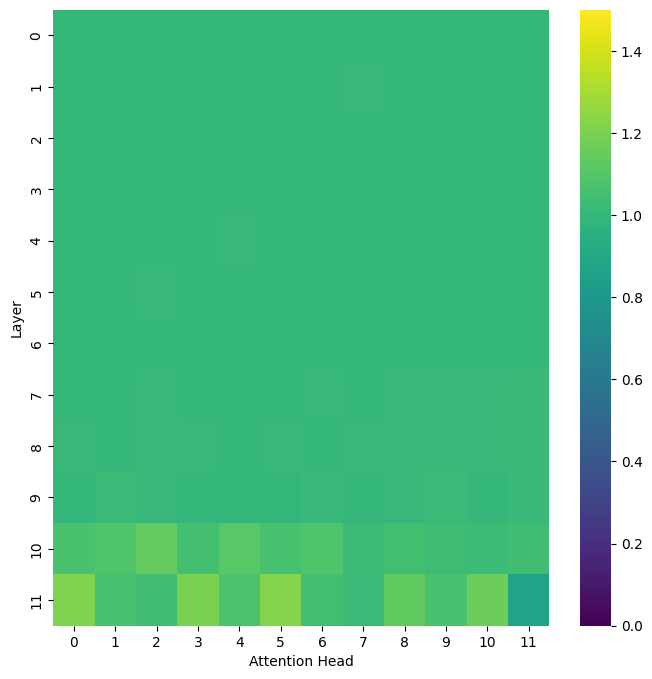

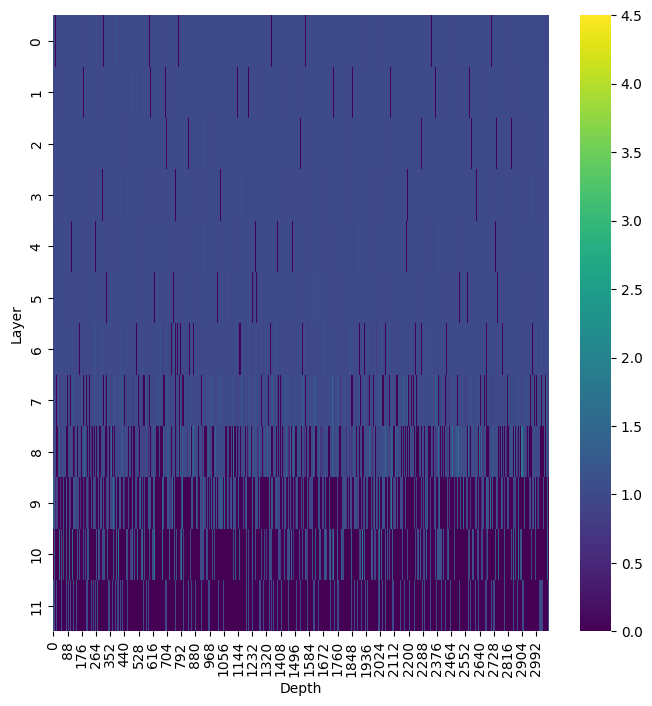

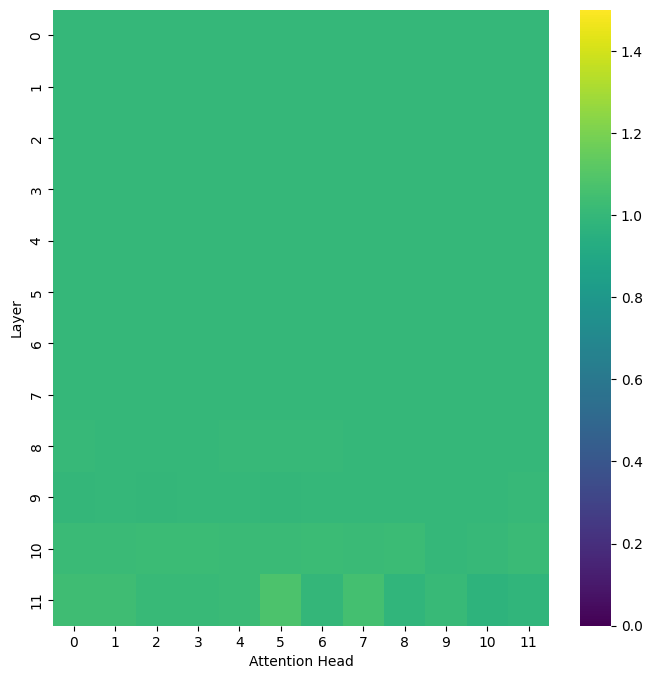

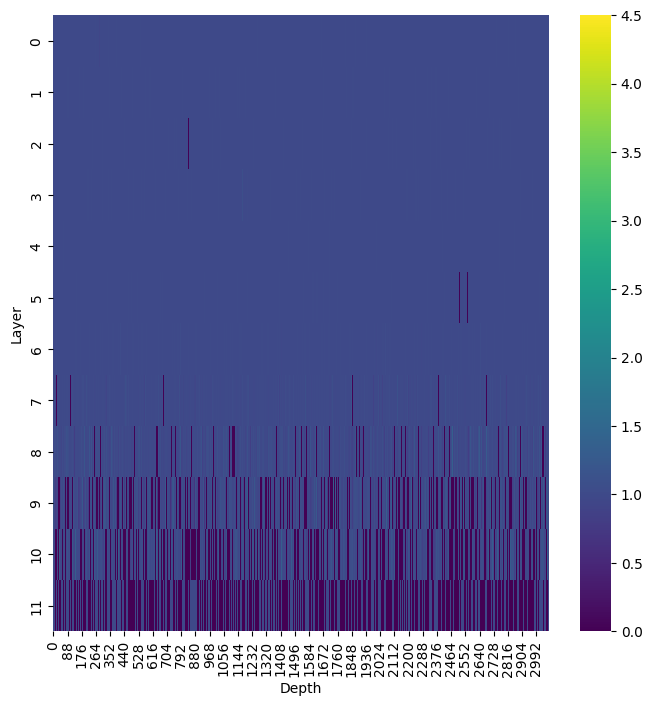

In [11]:
masks_dir = os.path.join(RESULTS_BASE, 'full_results', 'masks')

name_iter = range(10,90,10) if pruning_metric == 'latency' else range(10,100,10)

frames_neuron = []
frames_head = []
for prune_perc in name_iter:
    folder_id = "0."+ str(100-int(prune_perc))[0]

    folder_path = os.path.join(MASKS_BASE, pruning_metric, folder_id, "seed_0")
    head_mask_path = os.path.join(folder_path, "head_mask.pt")
    neuron_mask_path = os.path.join(folder_path, "neuron_mask.pt")
    
    head_mask = torch.load(head_mask_path, map_location=torch.device('cpu')).cpu().numpy()
    neuron_mask = torch.load(neuron_mask_path, map_location=torch.device('cpu')).cpu().numpy()

    plt.figure(figsize=(8,8))
    ax = sns.heatmap(head_mask, cmap="viridis", vmin=0, vmax=1.5)

    head_fig_path = os.path.join(masks_dir, pruning_metric, 'figures', f'attention_{prune_perc}_heatmap.jpg')
    plt.xlabel("Attention Head")
    plt.ylabel("Layer")
    plt.savefig(head_fig_path)

    ffn_fig_path = os.path.join(masks_dir, pruning_metric, 'figures', f'ffn_{prune_perc}_heatmap.jpg')
    plt.figure(figsize=(8,8))
    ax = sns.heatmap(neuron_mask, cmap="viridis", vmin=0, vmax=4.5)
    plt.xlabel("Depth")
    plt.ylabel("Layer")
    plt.savefig(ffn_fig_path)

    frames_neuron.append(Image.open(ffn_fig_path))
    frames_head.append(Image.open(head_fig_path))

frames_neuron[0].save(os.path.join(masks_dir, pruning_metric, 'figures', 'neuron_mask.gif'), 
                      format='GIF',
                      append_images=frames_neuron[1:],
                      save_all=True,
                      duration=100)

frames_head[0].save(os.path.join(masks_dir, pruning_metric, 'figures', 'head_mask.gif'), 
                      format='GIF',
                      append_images=frames_head[1:],
                      save_all=True,
                      duration=100)

If you prefer the output in a form of a GIF, see the cell below. Note that the animation may not get replayed properly when the cell is rerun (works on Google Colab). Therefore, it might be preferrable to simply view the saved gif images directly in demos/data/results/full_results/masks/{pruning metric}/figures/{neuron_mask.gif|head_mask.gif}

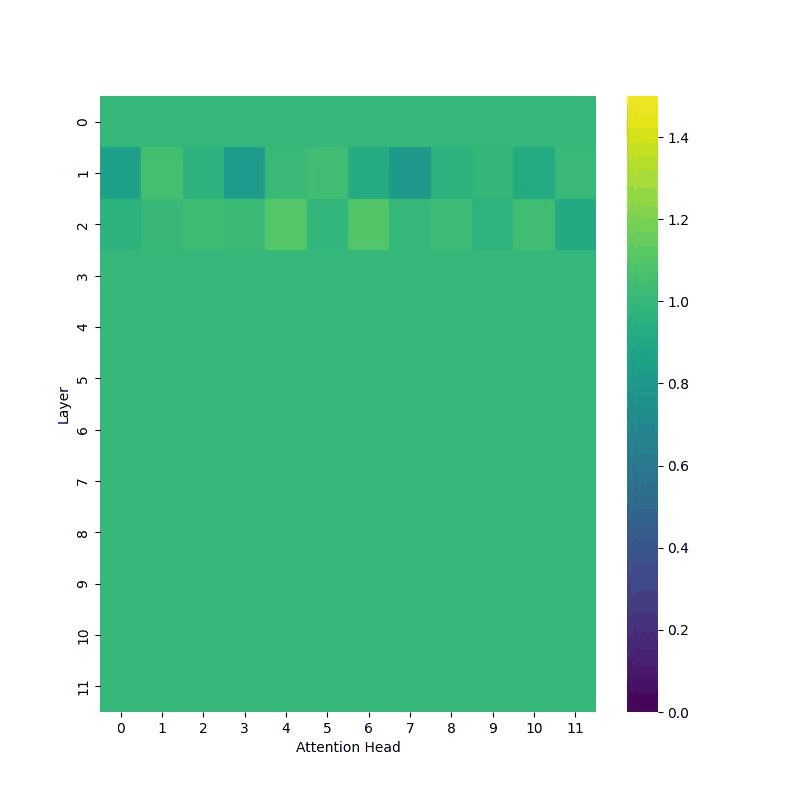

In [12]:
gif_path = os.path.join(masks_dir, pruning_metric, 'figures', 'head_mask.gif')
with open(gif_path,'rb') as f:
    display(IPyImage(data=f.read(), format='gif'))

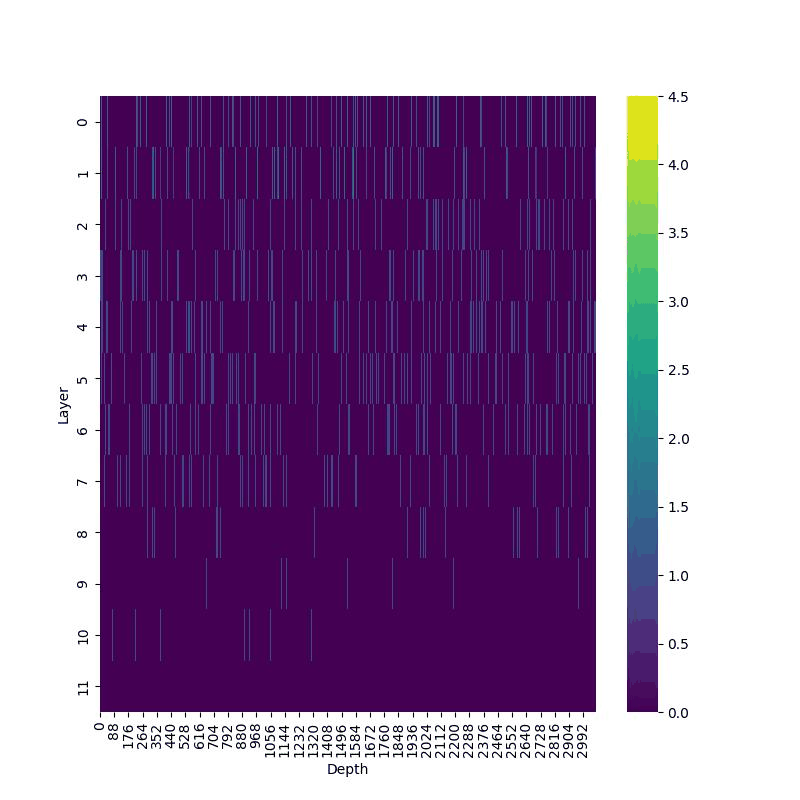

In [31]:
gif_path = os.path.join(masks_dir, pruning_metric, 'figures', 'neuron_mask.gif')
with open(gif_path,'rb') as f:
    display(IPyImage(data=f.read(), format='gif'))